## Initializing



In [4]:
# basic 
import pandas as pd
import numpy as np
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.diagnostic import het_breuschpagan

# models 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# os modules
import os
from pathlib import Path

# data
# from ucimlrepo import fetch_ucirepo 

# global parameters
seed = 2016

## helper function

In [6]:
# -------- Saving files ------- #
# Global path for sex-specific folder
current_sex_path = None

def set_sex_folder(sex_type: str):
    """Sets up a folder for the given sex type and creates it if it doesn't exist
    
    Args:
        sex_type (str): Sex identifier ('M', 'F', etc.) to be used in folder name
    """
    global current_sex_path
    folder_name = f"sex_{sex_type.lower()}"
    current_sex_path = Path(folder_name)
    
    # Create folder if it doesn't exist
    current_sex_path.mkdir(exist_ok=True)
    print(f"Set directory path: {current_sex_path.absolute()}")

def save_file_safe(data, filename: str, file_type: str = 'csv', *, skip_if_exists: bool = False, df_index=False):
    """
    Safely saves a file, with options to prevent overwriting or skip existing files
    
    Args:
        data: DataFrame (for CSV) or matplotlib figure/axis (for plots)
        filename: Base filename without extension
        file_type: File type ('csv', 'png', 'pdf', 'svg')
        skip_if_exists: If True, skips saving when file exists (default: False)
        df_index: Whether to save DataFrame index (for CSV only)
    
    Returns:
        Path: Full path to the saved file, or None if skipped
    
    Raises:
        ValueError: If sex folder isn't set or unsupported file type is provided
    """
    if current_sex_path is None:
        raise ValueError("First set sex folder using set_sex_folder()")
    
    # Supported plot formats
    plot_formats = {'png', 'pdf', 'svg'}
    
    # Create full file path
    base_path = current_sex_path / filename
    full_path = base_path.with_suffix(f'.{file_type}')
    
    # Check if file exists and handle according to parameters
    if full_path.exists():
        if skip_if_exists:
            print(f"File {full_path} already exists - skipping")
            return None
        else:
            # Find unique filename if file exists
            counter = 1
            while full_path.exists():
                new_name = f"{base_path.stem}_v{counter}{full_path.suffix}"
                full_path = full_path.with_name(new_name)
                counter += 1
    
    # Save file based on type
    if file_type == 'csv':
        data.to_csv(full_path, index=df_index)
    elif file_type in plot_formats:
        if hasattr(data, 'savefig'):  # Handle figure object
            data.savefig(full_path, bbox_inches='tight')
        elif hasattr(data, 'get_figure'):  # Handle axis object
            data.get_figure().savefig(full_path, bbox_inches='tight')
        else:
            plt.savefig(full_path, bbox_inches='tight')  # Save current figure
    else:
        raise ValueError(f"Unsupported file type. Use 'csv' or one of {plot_formats}")
    
    print(f"Saved file: {full_path}")
    return full_path

def file_exists(filename: str, file_type: str = 'csv') -> bool:
    """
    Checks if a file exists in the current sex-specific folder
    
    Args:
        filename: Base filename without extension
        file_type: File extension ('csv', 'jpeg', etc.)
    
    Returns:
        bool: True if file exists, False otherwise
    
    Raises:
        ValueError: If sex folder hasn't been set
    """
    if current_sex_path is None:
        raise ValueError("Sex folder not set. Call set_sex_folder() first")
    
    file_path = current_sex_path / f"{filename}.{file_type}"
    return file_path.exists()

def load_file(filename: str, file_type: str = 'csv', index_col=False):
    """
    Loads a file from the current sex-specific folder
    
    Args:
        filename: Base filename without extension
        file_type: File type ('csv', etc.)
    
    Returns:
        Loaded data (DataFrame for CSV) or None if file doesn't exist
    
    Raises:
        ValueError: If sex folder not set or unsupported file type
    """
    if current_sex_path is None:
        raise ValueError("Sex folder not set. Call set_sex_folder() first")
    
    file_path = current_sex_path / f"{filename}.{file_type}"
    
    if not file_path.exists():
        return None
        
    if file_type == 'csv':
        if index_col is not None:
            return pd.read_csv(file_path, index_col=0)
        return pd.read_csv(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")



# -------- Tests ------- #
# vifs calculation function
def vifs_calculation(df, entry_name=None):
    '''
    df need to be dataframe only with parameters to compare and with column names for print
    '''
    # calculating vifs
    col_names = df.columns
    df = sm.add_constant(df)
    vif_vals = [vif(df, i) for i in range(1, df.shape[1])]
    vif_dict = {name: [value] for name, value in zip(col_names, vif_vals)}
    # creating df 
    if entry_name is not None:
        vif_dict = {'NAME_INDEX': entry_name, **vif_dict}
        rtn_df = pd.DataFrame(vif_dict).set_index('NAME_INDEX')
    else:
        rtn_df = pd.DataFrame(vif_dict)

    return rtn_df



def F_test_normal(df, y, test_cols):
    '''
    Function takes DataFrame (df) with all features (implemented & new) and tests if new features (test_cols), bring significant difference.

    Assumptions:
    - std error ~ N with heteroskedasticity error, and normal distribution
    '''
    # creating basic feature df & model 
    X = df.drop(columns=test_cols)
    # X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=seed)
    model_1 = sm.OLS(y, sm.add_constant(X)).fit()
    # create table with all results (adding context WITH FEATURE NAME)
    compare_table = None

    # TODO create loop (just range)
    for col_name in test_cols:
        # new features list
        X_new = pd.concat([X, df[col_name]], axis=1)
        # creating models (sm)
        model_2 = sm.OLS(y, sm.add_constant(X_new)).fit()
        # calculating values for every model change
        new_results = sm.stats.anova_lm(model_1, model_2)
        new_results['Model'] = pd.Series(['Model Standardowy', col_name]) 
        new_results = new_results[list(new_results.columns[-1:]) + list(new_results.columns[:-1])]
        # TODO UPDATE table
        if compare_table is None:
            # create template
            compare_table = new_results
        else:
            # update data 
            compare_table = pd.concat([compare_table, new_results.iloc[[1], :]], axis=0)
    # returning df with data 
    return compare_table.set_index('Model')

    
def F_test_permutation(df, y, test_cols, n):
    '''
    Tests if new features (test_cols) bring significant improvement
    
    Parameters:
    -----------
    df : DataFrame
        Contains all features
    y : array-like
        Target variable
    test_cols : list
        List of columns to test
    n_perm : int
        Number of permutations (recommended ≥5000)
        
    Returns:
    --------
    DataFrame with results for each tested feature
    '''
    # local variables 
    # TODO zrobić wersje z results i później dodawanie ponieważ kod wygląda czytelniej. 
    rtn_df = list()
    X_reduced = df.drop(columns=test_cols)

    # loop through test_cols
    for test_col in test_cols:
        # creating df for moddels 
        full_features = test_cols.copy()
        full_features.remove(test_col)
        X_full = df.drop(columns=full_features)

        # creating models     
        model_reduced = sm.OLS(y, sm.add_constant(X_reduced)).fit()
        model_full = sm.OLS(y, sm.add_constant(X_full)).fit() 

        # finding f_stat
        f_stat, p_value, df_diff = model_full.compare_f_test(model_reduced)
        
        # permutation procedure
        f_stats = list()
        for _ in range(n):
            # permutate X_new
            X_full[test_col] = np.random.permutation(df[test_col])
            # creating model
            model_full = sm.OLS(y, sm.add_constant(X_full)).fit()
            # finding F_stat
            f_perm = model_full.compare_f_test(model_reduced)[0]
            # saving f_stats
            f_stats.append(f_perm)
        
        # compare F_stat 
        f_pos_sum = np.sum(f_stats >= f_stat)
        p_value = (f_pos_sum + 1) / (n + 1)
        
        # creating df entry
        row = {
            'Tested feature': test_col,
            'F statistic': f_stat,
            'P_statistic': f_pos_sum,
            'P value': p_value,
        }
        rtn_df.append(row)

    return pd.DataFrame(rtn_df).set_index('Tested feature')

# TODO bootstrapping method (method to comparison )
def lr_reduction_coef_significance_bootstrap(df, y, test_cols, n):
    # local variables 
    pass

    # TODO bootstraping 

    # TODO calculating statistis 

    # returning results 

## load data

In [76]:
# parameters
COL_NAMES = ['Płeć', 'Długość', 'Średnica', 'Wysokość', 'Cała# -------- Loading data ------- #_waga', 'Waga_po_obraniu', 'Waga_trzewi', 'Waga_powłoki', 'Pierścienie']
DATA_PATH = Path.cwd() / 'abalone_data_set.csv'

# -------- Loading data ------- #
# externally
if not DATA_PATH.exists():
    abalone = fetch_ucirepo(id=1) 
    # data (as pandas dataframes) 
    X_reduced = abalone.data.features 
    y = abalone.data.targets 
    df = pd.concat([X_reduced, y], axis=1)
    df.columns = COL_NAMES
    #saving data 
    df.to_csv('abalone_data_set.csv', index=False)
    df.to_excel('abalone_data_set.xlsx', index=False)
# locally 
else:
    df = pd.read_csv('abalone_data_set.csv')


# -------- adjusting data ------- #
X_reduced = df.drop('Pierścienie', axis=1)
y = df[['Pierścienie']]
# decoding categorical data (as boolean) 
X_reduced['Płeć_M'] = (X_reduced['Płeć'] == 'M')
X_reduced['Płeć_F'] = (X_reduced['Płeć'] == 'F')
X_reduced['Płeć_I'] = (X_reduced['Płeć'] == 'I')
X_reduced = X_reduced[list(X_reduced.columns[-3:]) + list(X_reduced.columns[1:-3])]

# X
df
    

,Płeć,Długość,Średnica,Wysokość,Cała_waga,Waga_po_obraniu,Waga_trzewi,Waga_powłoki,Pierścienie
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


### analiza korelacji 

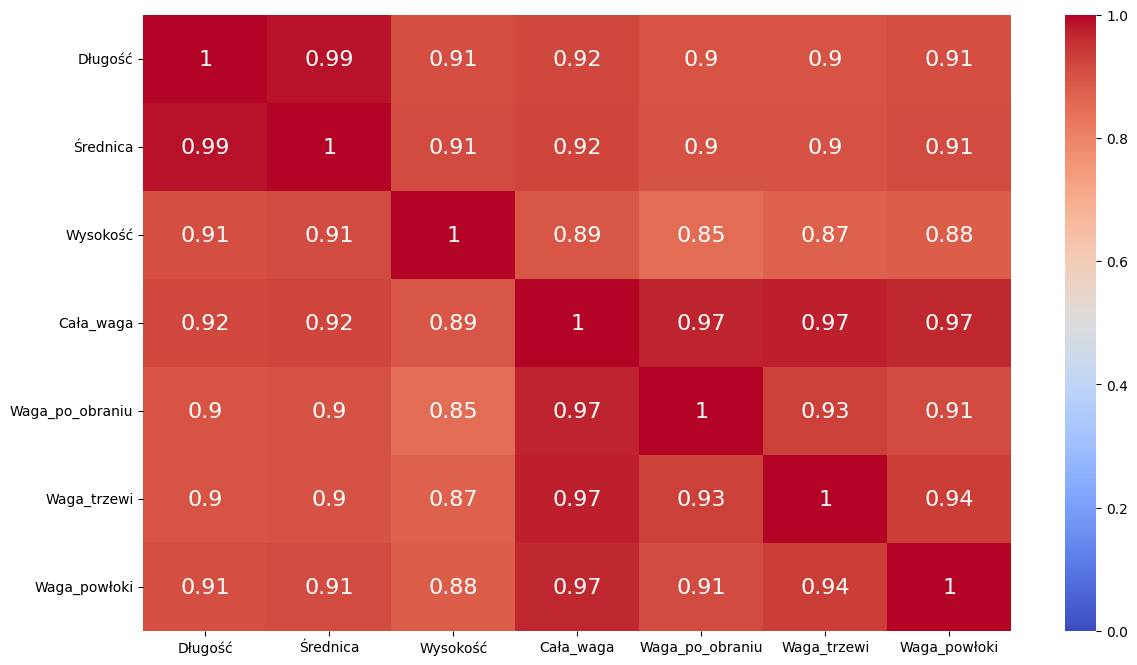

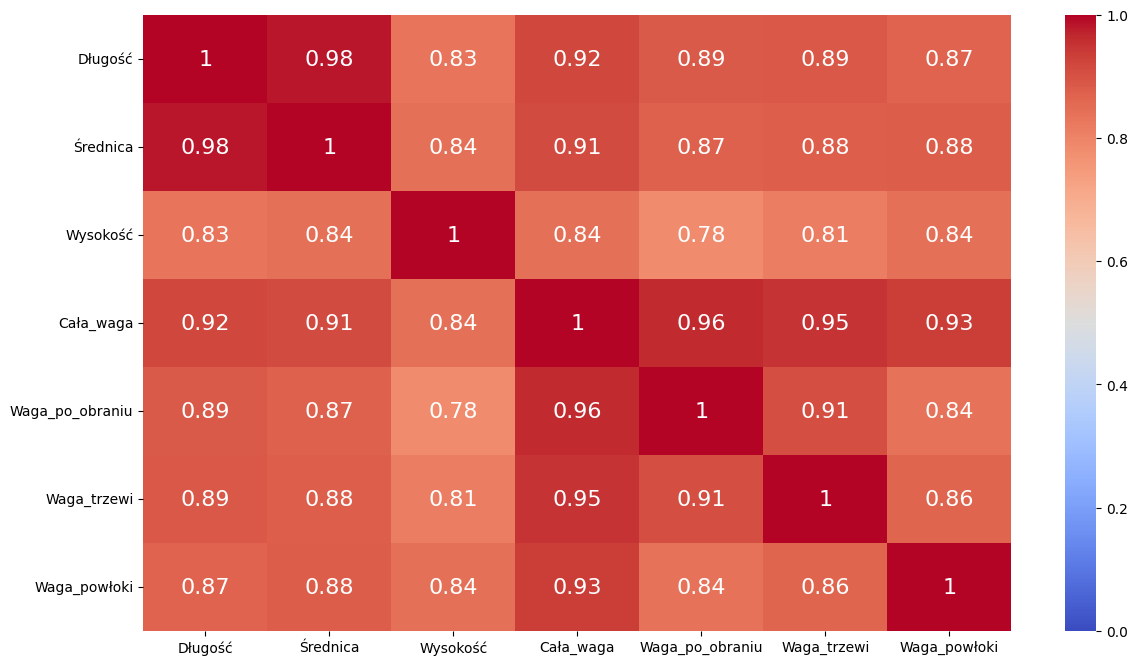

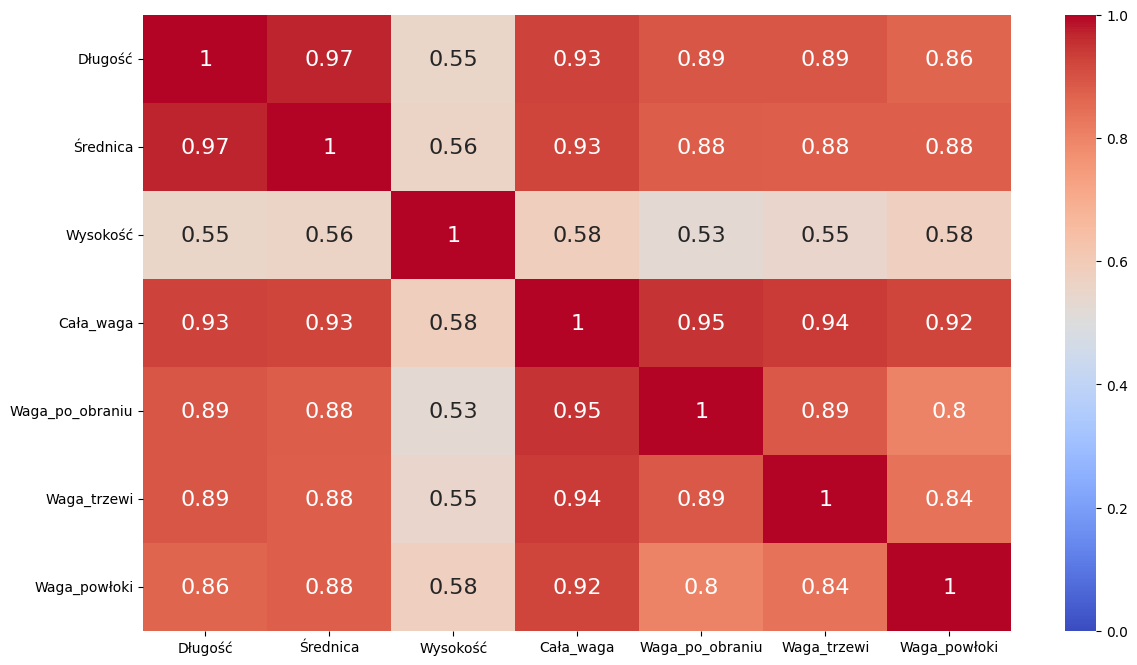

In [8]:
# -------- parameters ------- #
sex_columns = ['Płeć_I', 'Płeć_M', 'Płeć_F']

# ------- correlation ------- #
for sex in sex_columns:
    plt.figure(figsize=(14, 8))
    sns.heatmap((X_reduced[X_reduced[f'{sex}'] == True].iloc[:, 3:]).corr(), 
                annot=True, cmap='coolwarm', vmin=0, vmax=1, annot_kws={"fontsize": 16})
    # plt.title(f'Korelacja dla {sex[-1]}')
    plt.savefig(f'Korelacja_podstawowe_zmienne_{sex}.png', dpi=150, bbox_inches='tight')
    plt.show()


## selection of new featrues
we first create all variables in *X_new* to compare it them to old ones. Important assumption here is that standard feature. We do for it for every *sex* separately. 

In [77]:
# create all variables

# ------- creating distinct model ------- #

# choosing F sex 
SEX = 'I'
filt = X_reduced[f'Płeć_{SEX}'] == True

# creating path
set_sex_folder(SEX)

# creating local variables 
y_local = y[filt]
X_old = X_reduced[filt].drop(columns=sex_columns).copy()
# new features 
X_new = X_old.copy()


# ------- creating new features ------- #
# ratio of dimensions 
X_new['Długość/Wysokość'] = X_reduced['Długość'] / X_reduced['Wysokość']
# mass / volume  
X_new['Masa/objętość'] = X_reduced['Cała_waga'] / (X_reduced['Długość'] * X_reduced['Średnica'] * X_reduced['Wysokość'])
# ratio of masses 
X_new['Waga_powłoki/Cała_waga'] = X_reduced['Waga_powłoki'] / X_reduced['Cała_waga']
X_new['Waga_po_obraniu/Cała_waga'] = X_reduced['Waga_po_obraniu'] / X_reduced['Cała_waga']
X_new['Waga_trzewi/Cała_waga'] = X_reduced['Waga_trzewi'] / X_reduced['Cała_waga']
X_new['Waga_powłoki/Waga_po_obraniu'] = X_reduced['Waga_powłoki'] / X_reduced['Waga_po_obraniu']
X_new['Waga_trzewi/Waga_po_obraniu'] = X_reduced['Waga_trzewi'] / X_reduced['Waga_po_obraniu']
X_new['Waga_trzewi/Waga_powłoki'] = X_reduced['Waga_trzewi'] / X_reduced['Waga_powłoki']

# ------- dropping critical values ------- #
invalid_rows = X_new.isna().any(axis=1) | np.isinf(X_new).any(axis=1)
X_old = X_old[~invalid_rows]
X_new = X_new[~invalid_rows]
y_local = y_local[~invalid_rows]




NEW_FEATURE_NAMES = list(X_new.columns[X_old.shape[1]:])

Set directory path: /Users/Max/studia - programowanie/econometry_project_abalone/sex_i


## Analiza reszt modelu

File sex_i/Wykres reszt, QQ plot.png already exists - skipping


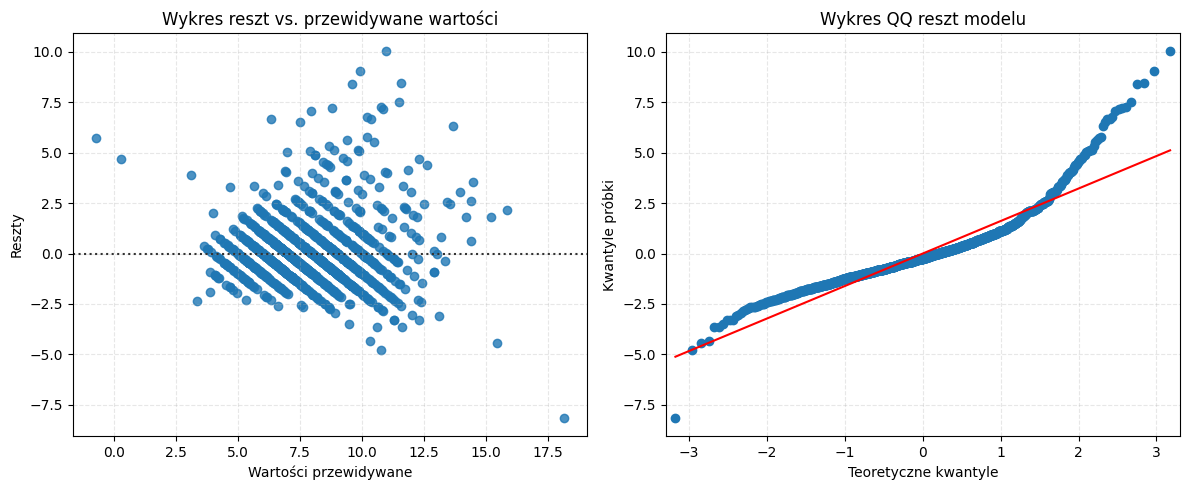

P value testu Shapiro-Wilka: 2.886829945254031e-30
Breusch-Pagan test p-value: 6.006540065062469e-23


In [78]:
# ------- creating variables ------- #
# Linear model (z const)
X_old_with_const = sm.add_constant(X_old)  # Dodaj stałą do danych treningowych
lm_old = sm.OLS(y_local, X_old_with_const).fit()

# Residuals (użyj X_old_with_const w predict!)
residuals = (y_local.to_numpy().flatten() - lm_old.predict(X_old_with_const)).values.ravel()  # Oblicz reszty

# ------- plotting ------- #
# create figure with 2 subplots
plt.figure(figsize=(12, 5))


# Residual plot (seaborn)
plt.subplot(1, 2, 1)
sns.residplot(
    x=lm_old.predict(X_old_with_const), 
    y=residuals, 
    lowess=False, 
    line_kws={'color': 'red', 'lw': 1}
)
plt.xlabel("Wartości przewidywane")
plt.ylabel("Reszty")
plt.grid(True, linestyle='--', alpha=0.3)
plt.title("Wykres reszt vs. przewidywane wartości")

# QQ plot 
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('Wykres QQ reszt modelu')
plt.xlabel('Teoretyczne kwantyle')
plt.ylabel('Kwantyle próbki')
plt.grid(True, linestyle='--', alpha=0.3)

# Adjust layout and save plot
plt.tight_layout()
save_file_safe(plt, 'Wykres reszt, QQ plot', 'png', skip_if_exists=True)
plt.show()

# ------- tests ------- #
# Normality test
normality_test_results = stats.shapiro(residuals)
print(f'P value testu Shapiro-Wilka: {normality_test_results.pvalue}')

homoskedacity_test = het_breuschpagan(residuals, X_old_with_const)[1]
print(f"Breusch-Pagan test p-value: {homoskedacity_test}")

## Reduction of features

`UWAGA`

tutaj rozpatrujemy przypadek dla zmiennych użytych w doborze zmiennych objaśniających

Dla I odrzucamy jeszcze wage trzewi ze względuna

In [79]:
# ------- vifs for basic model ------- #
vifs_basic = vifs_calculation(X_old, 'Model bazowy')
print(vifs_basic)
print(f'\n\n\n')
# ------- vifs for reduce model ------- #
reduce_basic = ['Cała_waga', 'Długość']
vifs_basic_after_red  = vifs_calculation(X_old.drop(columns=reduce_basic), 'Model bazowy po redukcji')
print(vifs_basic_after_red)

# creating X_final features df (we want obtain it) 
X_final = X_new.drop(columns=reduce_basic)


# to jest uzasadnienie mojej decyzji ~ współczynnik zmalał o małą wartość (potem przeliczyć jeszcze raz)
lm_new, lm_final = LinearRegression(), LinearRegression()
lm_new.fit(X_old, y_local), lm_final.fit(X_old.drop(columns=reduce_basic), y_local)
score_new, score_final = lm_new.score(X_old, y_local), lm_final.score(X_old.drop(columns=reduce_basic), y_local)
print(f'Score of initial model = {score_new}\nScore of final model = {score_final}')

# saving file
vifs_basic = pd.concat([vifs_basic, vifs_basic_after_red], axis=0)
save_file_safe(vifs_basic, 'vifs_basic_model', 'csv', df_index=True, skip_if_exists=True)


                Długość   Średnica  Wysokość   Cała_waga  Waga_po_obraniu  \
NAME_INDEX                                                                  
Model bazowy  37.542044  40.439508  7.504494  102.488834        23.216644   

              Waga_trzewi  Waga_powłoki  
NAME_INDEX                               
Model bazowy    20.809022     25.075522  




                           Średnica  Wysokość  Waga_po_obraniu  Waga_trzewi  \
NAME_INDEX                                                                    
Model bazowy po redukcji  10.061272  7.410882         9.093273    12.022501   

                          Waga_powłoki  
NAME_INDEX                              
Model bazowy po redukcji     12.579928  
Score of initial model = 0.5894093370778366
Score of final model = 0.5813638996781687
File sex_i/vifs_basic_model.csv already exists - skipping


In [80]:
# ------- calculating F_test for ceratin sex ------- #

# parameters
n_perm = 100_000
f_name = 'F_test_before_reduction'

if not file_exists(f_name, 'csv'):
    # calcualte F_test for features.  
    F_test_before_reduction = F_test_permutation(X_final, y_local, NEW_FEATURE_NAMES, n_perm)
    save_file_safe(F_test_before_reduction, 'F_test_before_reduction', 'csv', df_index=True)
else:
    F_test_before_reduction = load_file(f_name, 'csv', index_col=0)


Jak to działa:

$H_0$ - Nowa zmienna nie wnosi istotnej różnicy
#H_A$ - Nowa zmienna wnosi istotną różnicę:

Konstrukcja 

Tworzymy najpierw referencyjną wartośc F i potem symulujemy sytuacje gdzie H_0 jest prawdziwa, czyli dla przemieszanej wartości X'a sprawdzamy czy dostajemy lepszy czy gorszy wynik. Jeżeli dostajemy lepszy wynik w większości przypadków to znaczy że nie mamy powodu sądzić że nasza zmienna wnosi jakiś wkład ponieważ wyniki po permutacji dają podobne rezultaty jeżeli chodzi o tłumaczenie wariancji modelu

In [ ]:
# ------- hypothesis testing for features with significant coefficents ------- #
# parameters
significant_level = 0.05
vif_reduce_value = 12

#  check hypothesis
F_test_before_reduction[f'Odrzucenie $H_0$ dla $\alpha = {significant_level}$'] = F_test_before_reduction['P value'] < significant_level
# create 
reduce_features_F_test = list(F_test_before_reduction[F_test_before_reduction['Odrzucenie $H_0$ dla $\alpha = 0.05$'] == False].index) 

# ------- reducing model based on vifs ------- #
# check vifs in reduce model 
index_name = 'Model rozszerzony przed redukcją vif'
reduce_features_vif_test = []
vifs_after_F_test = []
# calculating vifs
while True:
    # taking column with highest vif
    drop_features = reduce_features_F_test + reduce_features_vif_test
    local_vifs = vifs_calculation(X_final.drop(columns=drop_features), index_name)
    # finding column with max value
    max_vif_column = local_vifs.idxmax(axis=1).iloc[0]
    max_vif_value = local_vifs.max(axis=1).iloc[0] 
    # updating return value
    vifs_after_F_test.append(local_vifs)
    reduce_features_vif_test.append(max_vif_column)
    # breaking loop if conditions are met
    if max_vif_value < vif_reduce_value:
        break 

# ------- creating df for report ------- #
# creating vifs_F_test df
vifs_after_F_test = pd.concat(vifs_after_F_test, axis=0)

# ------- update of X_final ------- #
# TODO ~ repair code, we take into consideration wrong features and that is why we have so big scores, we should have fewer features, make this code more reusable
X_final = X_final.drop(columns=reduce_features_vif_test)

# ------- calculatting scores for models ------- #
lm_new, lm_final = LinearRegression(), LinearRegression()
lm_new.fit(X_new, y_local), lm_final.fit(X_final, y_local)
score_new, score_final = lm_new.score(X_new, y_local), lm_final.score(X_final, y_local)
print(f'Score of initial model = {score_new}\nScore of final model = {score_final}')

# TODO saving data 
save_file_safe(F_test_before_reduction, 'F_test_before_reduction', 'csv', df_index=True, skip_if_exists=True)
save_file_safe(vifs_after_F_test, 'vifs_after_F_test', 'csv', df_index=True, skip_if_exists=True)


ValueError: Unable to coerce to Series, length must be 4: given 1

In [85]:
X_final

,Wysokość,Waga_trzewi,Długość/Wysokość,Masa/objętość,Waga_powłoki/Cała_waga,Waga_po_obraniu/Cała_waga,Waga_trzewi/Cała_waga,Waga_powłoki/Waga_po_obraniu,Waga_trzewi/Waga_po_obraniu,Waga_trzewi/Waga_powłoki
4,0.080,0.0395,4.125000,30.451575,0.268293,0.436585,0.192683,0.614525,0.441341,0.718182
5,0.095,0.0775,4.473684,29.019608,0.341394,0.401138,0.220484,0.851064,0.549645,0.645833
16,0.085,0.0395,4.176471,34.382767,0.395869,0.327022,0.135972,1.210526,0.415789,0.343478
21,0.100,0.0490,3.800000,21.578947,0.376940,0.354767,0.217295,1.062500,0.612500,0.576471
42,0.045,0.0235,5.333333,37.037037,0.285714,0.450000,0.335714,0.634921,0.746032,1.175000
...,...,...,...,...,...,...,...,...,...,...
4158,0.110,0.0890,4.363636,23.981007,0.311457,0.447164,0.197998,0.696517,0.442786,0.635714
4163,0.085,0.0695,4.588235,33.474432,0.229651,0.526163,0.202035,0.436464,0.383978,0.879747
4164,0.100,0.0635,3.900000,25.154730,0.284710,0.441125,0.223199,0.645418,0.505976,0.783951
4165,0.085,0.0505,4.764706,29.387557,0.289951,0.494234,0.166392,0.586667,0.336667,0.573864


## Checking leverage values 

Set directory path: /Users/Max/studia - programowanie/econometry_project_abalone/sex_i
[1249   91]
0.0029850746268656717
[False False False ... False False False]
(1249, 5)
                            OLS Regression Results                            
Dep. Variable:            Pierścienie   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     441.5
Date:                ptk, 30 maj 2025   Prob (F-statistic):          1.88e-242
Time:                        11:39:20   Log-Likelihood:                -2571.0
No. Observations:                1340   AIC:                             5152.
Df Residuals:                    1335   BIC:                             5178.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   co

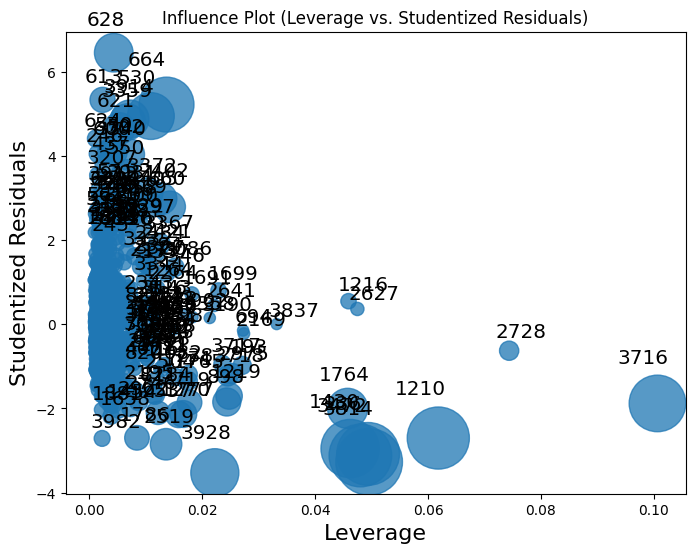

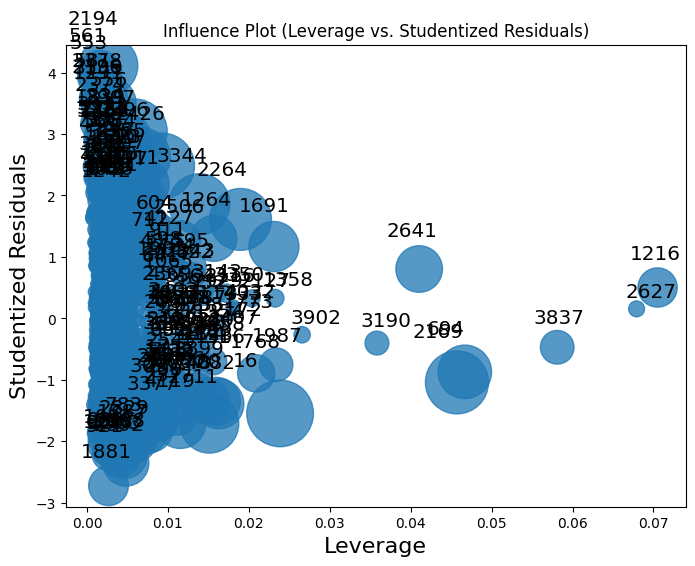

In [ ]:
# setting sex 
# TODO check if everything with model is ok because we get different results than in upper chunk
SEX = 'I'
set_sex_folder(SEX)
# loading data (vifs)
df = load_file('vifs_after_F_test')
# selecting columns which met reduction conditions
X = sm.add_constant(X_new[df.columns[df.iloc[-1].notnull()]])
y = y_local

leverage_final_results = dict()
# creating loop for iteration
for i in range(2):
    # finding model 
    ols = sm.OLS(y, X).fit()
    ols_influence = ols.get_influence()
    leverages = ols_influence.hat_matrix_diag # to nam zwraca jakie wartości mają dużą dźwignie 
    cooks = ols_influence.cooks_distance[0]
    threshold = 4/X.shape[0]
    filt = cooks > threshold
    X = X[~filt]
    y = y[~filt]

    # adding values
    

    # Plot the influence plot (multivariate)
    fig, ax = plt.subplots(figsize=(8, 6))
    sm.graphics.influence_plot(ols, ax=ax, criterion="cooks")
    ax.set_title("Influence Plot (Leverage vs. Studentized Residuals)")
    plt.show()


# finding leverage values (first iteration)
ols = sm.OLS(y, X).fit()
ols_influence = ols.get_influence()
leverages = ols_influence.hat_matrix_diag # to nam zwraca jakie wartości mają dużą dźwignie 
cooks = ols_influence.cooks_distance[0]
threshold = 4/X.shape[0]
filt = cooks > threshold
X = X[~filt]
y = y[~filt]

# TODO ~ obscure code 
# validation :) 
print(np.bincount(cooks > threshold))
print(threshold)
print((cooks > threshold))
print(X.shape)
# comparison of two models
print(ols.summary())
print(ols_2.summary())
# it is working we get 0.07 more R score (pretty huge amount) 



## Checking box-cox transformation for each variable 